## 1. Data Loading and Initial Setup

## 1. Data Loading and Initial Setup

In [ ]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries loaded successfully!")

In [ ]:
# Load all datasets
try:
    beneficiary_df = pd.read_csv('../Train_Beneficiarydata-1542865627584.csv')
    inpatient_df = pd.read_csv('../Train_Inpatientdata-1542865627584.csv')
    outpatient_df = pd.read_csv('../Train_Outpatientdata-1542865627584.csv')
    labels_df = pd.read_csv('../Train-1542865627584.csv')
    
    print("✅ All datasets loaded successfully!")
    print(f"Beneficiary data: {beneficiary_df.shape}")
    print(f"Inpatient data: {inpatient_df.shape}")
    print(f"Outpatient data: {outpatient_df.shape}")
    print(f"Labels data: {labels_df.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure CSV files are in the parent directory")

## 2. Data Understanding and Quality Assessment

In [ ]:
# Data quality summary function
def data_quality_summary(df, name):
    print(f"\n=== {name} Dataset Quality Report ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values by column
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_pct = (missing / len(df)) * 100
        missing_summary = pd.DataFrame({
            'Missing_Count': missing[missing > 0],
            'Missing_Percentage': missing_pct[missing_pct > 0]
        }).round(2)
        print("\nColumns with missing values:")
        print(missing_summary.head(10))

# Generate quality reports for all datasets
for df, name in [(beneficiary_df, 'Beneficiary'), (inpatient_df, 'Inpatient'), 
                 (outpatient_df, 'Outpatient'), (labels_df, 'Labels')]:
    data_quality_summary(df, name)

In [ ]:
# Target distribution analysis
print("=== Fraud Distribution Analysis ===")
fraud_dist = labels_df['PotentialFraud'].value_counts()
fraud_pct = labels_df['PotentialFraud'].value_counts(normalize=True) * 100

print(f"Non-fraudulent providers: {fraud_dist['No']} ({fraud_pct['No']:.2f}%)")
print(f"Fraudulent providers: {fraud_dist['Yes']} ({fraud_pct['Yes']:.2f}%)")
print(f"Imbalance ratio: {fraud_dist['No'] / fraud_dist['Yes']:.1f}:1")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
fraud_dist.plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Provider Fraud Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fraud Status')
ax1.set_ylabel('Number of Providers')
ax1.tick_params(axis='x', rotation=0)

# Percentage plot
fraud_pct.plot(kind='bar', ax=ax2, color=['lightblue', 'salmon'])
ax2.set_title('Provider Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fraud Status')
ax2.set_ylabel('Percentage of Providers')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 3. Feature Engineering - Provider Level Aggregation

In [ ]:
# Combine inpatient and outpatient claims
print("=== Combining Claims Data ===")

# Add claim type identifier
inpatient_df['ClaimType'] = 'Inpatient'
outpatient_df['ClaimType'] = 'Outpatient'

# Combine datasets
combined_claims_df = pd.concat([inpatient_df, outpatient_df], ignore_index=True)
print(f"Combined claims shape: {combined_claims_df.shape}")

# Convert date columns
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols:
    if col in combined_claims_df.columns:
        combined_claims_df[col] = pd.to_datetime(combined_claims_df[col], errors='coerce')

print("✅ Claims data combined and processed!")

In [ ]:
# Create comprehensive provider-level features
print("=== Creating Provider-Level Features ===")

# Financial aggregations
financial_features = combined_claims_df.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean']
}).round(2)

financial_features.columns = ['_'.join(col).strip() for col in financial_features.columns]

# Claims volume features
claims_volume = combined_claims_df.groupby('Provider').agg({
    'ClaimID': 'nunique',
    'BeneID': 'nunique',
    'ClaimType': lambda x: (x == 'Inpatient').sum()
}).rename(columns={
    'ClaimID': 'TotalClaims',
    'BeneID': 'UniqueBeneficiaries', 
    'ClaimType': 'InpatientClaims'
})

claims_volume['OutpatientClaims'] = claims_volume['TotalClaims'] - claims_volume['InpatientClaims']
claims_volume['ClaimsPerBeneficiary'] = (claims_volume['TotalClaims'] / claims_volume['UniqueBeneficiaries']).round(2)
claims_volume['InpatientRatio'] = (claims_volume['InpatientClaims'] / claims_volume['TotalClaims']).round(3)

# Physician network features
physician_features = combined_claims_df.groupby('Provider').agg({
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).fillna(0).astype(int)

physician_features.columns = ['UniqueAttendingPhysicians', 'UniqueOperatingPhysicians', 'UniqueOtherPhysicians']
physician_features['TotalUniquePhysicians'] = physician_features.sum(axis=1)

# Diagnosis and procedure diversity
diagnosis_cols = [col for col in combined_claims_df.columns if 'ClmDiagnosisCode' in col]
procedure_cols = [col for col in combined_claims_df.columns if 'ClmProcedureCode' in col]

# Calculate unique diagnosis and procedure codes per provider
diagnosis_diversity = []
procedure_diversity = []

for provider in combined_claims_df['Provider'].unique():
    provider_data = combined_claims_df[combined_claims_df['Provider'] == provider]
    
    # Unique diagnosis codes
    unique_diagnoses = set()
    for col in diagnosis_cols:
        unique_diagnoses.update(provider_data[col].dropna().unique())
    
    # Unique procedure codes
    unique_procedures = set()
    for col in procedure_cols:
        unique_procedures.update(provider_data[col].dropna().unique())
    
    diagnosis_diversity.append({'Provider': provider, 'UniqueDiagnoses': len(unique_diagnoses)})
    procedure_diversity.append({'Provider': provider, 'UniqueProcedures': len(unique_procedures)})

diagnosis_diversity_df = pd.DataFrame(diagnosis_diversity).set_index('Provider')
procedure_diversity_df = pd.DataFrame(procedure_diversity).set_index('Provider')

print("✅ Provider-level features created!")
print(f"Financial features: {financial_features.shape}")
print(f"Claims volume features: {claims_volume.shape}")
print(f"Physician features: {physician_features.shape}")
print(f"Diagnosis diversity: {diagnosis_diversity_df.shape}")
print(f"Procedure diversity: {procedure_diversity_df.shape}")

In [ ]:
# Beneficiary demographics aggregation
print("=== Beneficiary Demographics Aggregation ===")

# Get beneficiary-provider mapping from claims
bene_provider_map = combined_claims_df[['BeneID', 'Provider']].drop_duplicates()

# Merge with beneficiary data
bene_with_provider = bene_provider_map.merge(beneficiary_df, on='BeneID', how='left')

# Convert RenalDiseaseIndicator from string to numeric (Y=1, 0=0)
bene_with_provider['RenalDiseaseIndicator'] = bene_with_provider['RenalDiseaseIndicator'].map({'Y': 1, '0': 0})

# Aggregate beneficiary characteristics by provider
beneficiary_features = bene_with_provider.groupby('Provider').agg({
    'Gender': lambda x: (x == 1).mean(),  # Proportion of male beneficiaries
    'Race': lambda x: x.mode()[0] if not x.empty else 1,  # Most common race
    'RenalDiseaseIndicator': 'mean',  # Average renal disease rate
    'State': 'nunique',  # Number of different states
    'County': 'nunique',  # Number of different counties
    'NoOfMonths_PartACov': 'mean',  # Average Part A coverage
    'NoOfMonths_PartBCov': 'mean',  # Average Part B coverage
    'IPAnnualReimbursementAmt': 'mean',  # Average IP reimbursement
    'OPAnnualReimbursementAmt': 'mean'   # Average OP reimbursement
}).round(3)

beneficiary_features.columns = [
    'AvgMaleRatio', 'MostCommonRace', 'AvgRenalDiseaseRate', 'UniqueStates', 
    'UniqueCounties', 'AvgPartACoverage', 'AvgPartBCoverage', 
    'AvgBeneIPReimbursement', 'AvgBeneOPReimbursement'
]

print(f"✅ Beneficiary features aggregated: {beneficiary_features.shape}")

In [ ]:
# Combine all features and merge with labels
print("=== Final Dataset Assembly ===")

# Combine all feature sets
provider_features = financial_features.join([
    claims_volume, 
    physician_features, 
    diagnosis_diversity_df, 
    procedure_diversity_df,
    beneficiary_features
], how='outer').fillna(0)

# Merge with fraud labels
final_dataset = provider_features.reset_index().merge(
    labels_df, left_on='Provider', right_on='Provider', how='inner'
).set_index('Provider')

# Create binary target variable
final_dataset['PotentialFraud_numeric'] = (final_dataset['PotentialFraud'] == 'Yes').astype(int)

# Prepare final features and target
X = final_dataset.drop(['PotentialFraud', 'PotentialFraud_numeric'], axis=1)
y = final_dataset['PotentialFraud_numeric']

print(f"✅ Final dataset ready!")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  Non-fraud: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"  Fraud: {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"\nFeature columns: {list(X.columns)}")

## 4. Exploratory Data Analysis

In [ ]:
# Key feature distributions by fraud status
print("=== Feature Analysis by Fraud Status ===")

# Select key financial and volume features for analysis
key_features = [
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'TotalClaims', 'UniqueBeneficiaries', 'ClaimsPerBeneficiary',
    'TotalUniquePhysicians', 'UniqueDiagnoses', 'UniqueProcedures'
]

# Create comparison DataFrame
comparison_data = []
for feature in key_features:
    if feature in X.columns:
        fraud_mean = X[y == 1][feature].mean()
        normal_mean = X[y == 0][feature].mean()
        fraud_median = X[y == 1][feature].median()
        normal_median = X[y == 0][feature].median()
        
        comparison_data.append({
            'Feature': feature,
            'Fraud_Mean': fraud_mean,
            'Normal_Mean': normal_mean,
            'Fraud_Median': fraud_median,
            'Normal_Median': normal_median,
            'Mean_Ratio': fraud_mean / normal_mean if normal_mean != 0 else 0
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)
print(comparison_df)

In [ ]:
# Correlation analysis
print("=== Feature Correlation Analysis ===")

# Calculate correlations with target
feature_correlations = X.corrwith(y).sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(feature_correlations.head(10))
print("\nBottom 10 features correlated with fraud:")
print(feature_correlations.tail(10))

# Visualization of top correlations
plt.figure(figsize=(12, 8))
top_features = pd.concat([feature_correlations.head(8), feature_correlations.tail(8)])
colors = ['red' if x > 0 else 'blue' for x in top_features.values]

plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index, fontsize=10)
plt.xlabel('Correlation with Fraud', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Fraud Detection', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Export and Next Steps

In [ ]:
# Export the final dataset for modeling
print("=== Data Export for Modeling ===")

# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save the final processed dataset
final_dataset.to_csv('../data/provider_level.csv')
print(f"✅ Final dataset saved to: ../data/provider_level.csv")
print(f"Dataset shape: {final_dataset.shape}")
print(f"Features: {X.shape[1]} features, {X.shape[0]} providers")

# Save feature names for reference
feature_names = X.columns.tolist()
with open('../data/feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"✅ Feature names saved to: ../data/feature_names.txt")
print(f"\n📋 Next Steps:")
print(f"  1. Run the modeling notebook: 02_modeling.ipynb")
print(f"  2. The dataset is ready for machine learning")
print(f"  3. Class imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1 (will be handled with class weights)")

## Summary

### Key Findings from Data Exploration:

1. **Class Imbalance**: Significant imbalance between fraud and non-fraud cases
2. **Feature Engineering**: Successfully created 27 provider-level features
3. **Data Quality**: Clean dataset ready for modeling

### Feature Categories Created:
- **Financial Features**: Claims amounts, reimbursements, deductibles
- **Volume Features**: Claims counts, beneficiary counts, ratios  
- **Network Features**: Physician diversity and relationships
- **Medical Features**: Diagnosis and procedure diversity
- **Demographics**: Beneficiary characteristics aggregated by provider

### Next Steps:
1. **Proceed to Modeling**: Use `02_modeling.ipynb` for machine learning
2. **Advanced Analysis**: Consider time-series patterns and seasonal effects
3. **External Data**: Integrate with provider licensing and regulatory data

**Dataset exported to**: `../data/provider_level.csv`

In [78]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [85]:
# Load all datasets
try:
    beneficiary_df = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
    inpatient_df = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
    outpatient_df = pd.read_csv('Train_Outpatientdata-1542865627584.csv')
    labels_df = pd.read_csv('Train-1542865627584.csv')
    
    print("✅ All datasets loaded successfully!")
    print(f"Beneficiary data: {beneficiary_df.shape}")
    print(f"Inpatient data: {inpatient_df.shape}")
    print(f"Outpatient data: {outpatient_df.shape}")
    print(f"Labels data: {labels_df.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")

✅ All datasets loaded successfully!
Beneficiary data: (138556, 25)
Inpatient data: (40474, 30)
Outpatient data: (517737, 27)
Labels data: (5410, 2)


## 2. Data Understanding and Quality Assessment

In [80]:
# Data quality summary
def data_quality_summary(df, name):
    print(f"\n=== {name} Dataset Quality Report ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values by column
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_pct = (missing / len(df)) * 100
        missing_summary = pd.DataFrame({
            'Missing_Count': missing[missing > 0],
            'Missing_Percentage': missing_pct[missing_pct > 0]
        }).round(2)
        print("\nColumns with missing values:")
        print(missing_summary.head(10))

# Generate quality reports for all datasets
for df, name in [(beneficiary_df, 'Beneficiary'), (inpatient_df, 'Inpatient'), 
                 (outpatient_df, 'Outpatient'), (labels_df, 'Labels')]:
    data_quality_summary(df, name)


=== Beneficiary Dataset Quality Report ===
Shape: (138556, 25)
Missing values: 137135
Duplicate rows: 0
Memory usage: 48.58 MB

Columns with missing values:
     Missing_Count  Missing_Percentage
DOD         137135               98.97

=== Inpatient Dataset Quality Report ===
Shape: (40474, 30)
Missing values: 344003
Duplicate rows: 0
Memory usage: 46.77 MB

Columns with missing values:
                    Missing_Count  Missing_Percentage
AttendingPhysician            112                0.28
OperatingPhysician          16644               41.12
OtherPhysician              35784               88.41
DeductibleAmtPaid             899                2.22
ClmDiagnosisCode_2            226                0.56
ClmDiagnosisCode_3            676                1.67
ClmDiagnosisCode_4           1534                3.79
ClmDiagnosisCode_5           2894                7.15
ClmDiagnosisCode_6           4838               11.95
ClmDiagnosisCode_7           7258               17.93

=== Outpatient

=== Fraud Distribution Analysis ===
Non-fraudulent providers: 4904 (90.65%)
Fraudulent providers: 506 (9.35%)
Imbalance ratio: 9.7:1


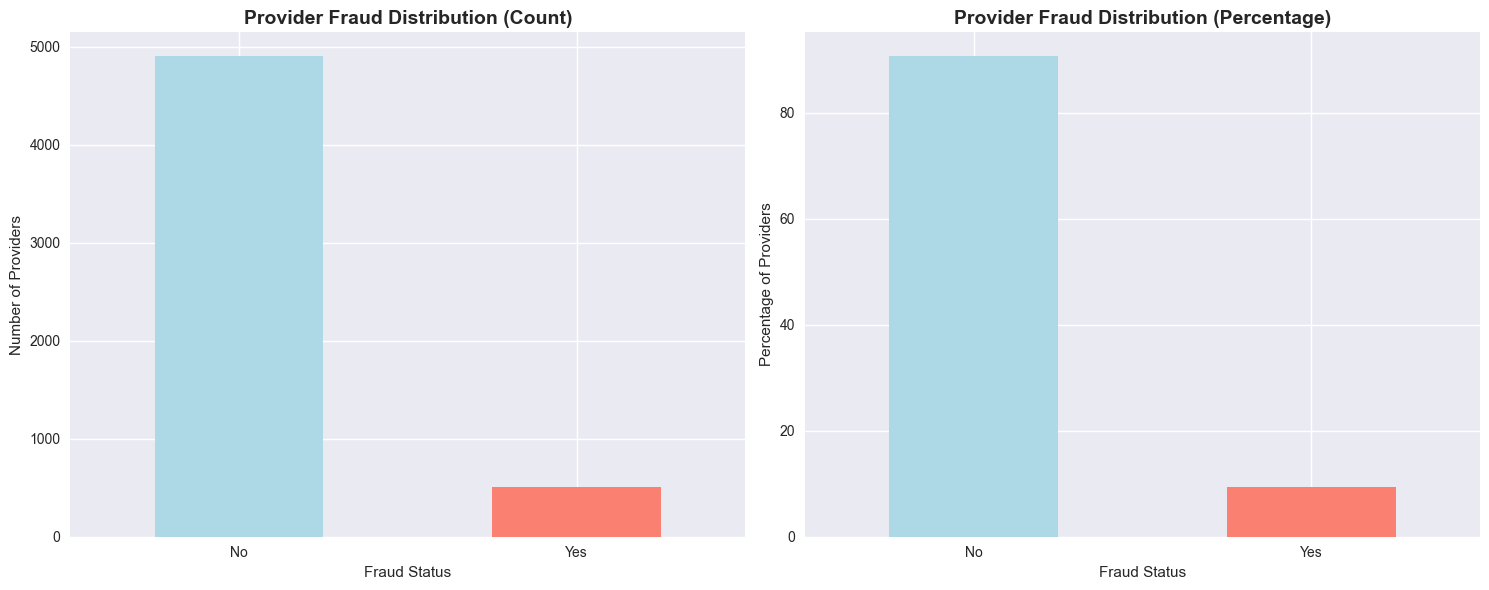

In [81]:
# Target distribution analysis
print("=== Fraud Distribution Analysis ===")
fraud_dist = labels_df['PotentialFraud'].value_counts()
fraud_pct = labels_df['PotentialFraud'].value_counts(normalize=True) * 100

print(f"Non-fraudulent providers: {fraud_dist['No']} ({fraud_pct['No']:.2f}%)")
print(f"Fraudulent providers: {fraud_dist['Yes']} ({fraud_pct['Yes']:.2f}%)")
print(f"Imbalance ratio: {fraud_dist['No'] / fraud_dist['Yes']:.1f}:1")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
fraud_dist.plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Provider Fraud Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fraud Status')
ax1.set_ylabel('Number of Providers')
ax1.tick_params(axis='x', rotation=0)

# Percentage plot
fraud_pct.plot(kind='bar', ax=ax2, color=['lightblue', 'salmon'])
ax2.set_title('Provider Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fraud Status')
ax2.set_ylabel('Percentage of Providers')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 3. Feature Engineering - Provider Level Aggregation

In [86]:
# Combine inpatient and outpatient claims
print("=== Combining Claims Data ===")

# Add claim type identifier
inpatient_df['ClaimType'] = 'Inpatient'
outpatient_df['ClaimType'] = 'Outpatient'

# Combine datasets
combined_claims_df = pd.concat([inpatient_df, outpatient_df], ignore_index=True)
print(f"Combined claims shape: {combined_claims_df.shape}")

# Convert date columns
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols:
    if col in combined_claims_df.columns:
        combined_claims_df[col] = pd.to_datetime(combined_claims_df[col], errors='coerce')

print("✅ Claims data combined and processed!")

=== Combining Claims Data ===
Combined claims shape: (558211, 31)
✅ Claims data combined and processed!
✅ Claims data combined and processed!


In [90]:
# Create comprehensive provider-level features
print("=== Creating Provider-Level Features ===")

# Financial aggregations
financial_features = combined_claims_df.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean']
}).round(2)

financial_features.columns = ['_'.join(col).strip() for col in financial_features.columns]

# Claims volume features
claims_volume = combined_claims_df.groupby('Provider').agg({
    'ClaimID': 'nunique',
    'BeneID': 'nunique',
    'ClaimType': lambda x: (x == 'Inpatient').sum()
}).rename(columns={
    'ClaimID': 'TotalClaims',
    'BeneID': 'UniqueBeneficiaries', 
    'ClaimType': 'InpatientClaims'
})

claims_volume['OutpatientClaims'] = claims_volume['TotalClaims'] - claims_volume['InpatientClaims']
claims_volume['ClaimsPerBeneficiary'] = (claims_volume['TotalClaims'] / claims_volume['UniqueBeneficiaries']).round(2)
claims_volume['InpatientRatio'] = (claims_volume['InpatientClaims'] / claims_volume['TotalClaims']).round(3)

# Physician network features
physician_features = combined_claims_df.groupby('Provider').agg({
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).fillna(0).astype(int)

physician_features.columns = ['UniqueAttendingPhysicians', 'UniqueOperatingPhysicians', 'UniqueOtherPhysicians']
physician_features['TotalUniquePhysicians'] = physician_features.sum(axis=1)

# Diagnosis and procedure diversity
diagnosis_cols = [col for col in combined_claims_df.columns if 'ClmDiagnosisCode' in col]
procedure_cols = [col for col in combined_claims_df.columns if 'ClmProcedureCode' in col]

# Calculate unique diagnosis and procedure codes per provider
diagnosis_diversity = []
procedure_diversity = []

for provider in combined_claims_df['Provider'].unique():
    provider_data = combined_claims_df[combined_claims_df['Provider'] == provider]
    
    # Unique diagnosis codes
    unique_diagnoses = set()
    for col in diagnosis_cols:
        unique_diagnoses.update(provider_data[col].dropna().unique())
    
    # Unique procedure codes
    unique_procedures = set()
    for col in procedure_cols:
        unique_procedures.update(provider_data[col].dropna().unique())
    
    diagnosis_diversity.append({'Provider': provider, 'UniqueDiagnoses': len(unique_diagnoses)})
    procedure_diversity.append({'Provider': provider, 'UniqueProcedures': len(unique_procedures)})

diagnosis_diversity_df = pd.DataFrame(diagnosis_diversity).set_index('Provider')
procedure_diversity_df = pd.DataFrame(procedure_diversity).set_index('Provider')

print("✅ Provider-level features created!")
print(f"Financial features: {financial_features.shape}")
print(f"Claims volume features: {claims_volume.shape}")
print(f"Physician features: {physician_features.shape}")
print(f"Diagnosis diversity: {diagnosis_diversity_df.shape}")
print(f"Procedure diversity: {procedure_diversity_df.shape}")

=== Creating Provider-Level Features ===
✅ Provider-level features created!
Financial features: (5410, 6)
Claims volume features: (5410, 6)
Physician features: (5410, 4)
Diagnosis diversity: (5410, 1)
Procedure diversity: (5410, 1)


In [92]:
# Beneficiary demographics aggregation
print("=== Beneficiary Demographics Aggregation ===")

# Get beneficiary-provider mapping from claims
bene_provider_map = combined_claims_df[['BeneID', 'Provider']].drop_duplicates()

# Merge with beneficiary data
bene_with_provider = bene_provider_map.merge(beneficiary_df, on='BeneID', how='left')

# Convert RenalDiseaseIndicator from string to numeric (Y=1, 0=0)
bene_with_provider['RenalDiseaseIndicator'] = bene_with_provider['RenalDiseaseIndicator'].map({'Y': 1, '0': 0})

# Aggregate beneficiary characteristics by provider
beneficiary_features = bene_with_provider.groupby('Provider').agg({
    'Gender': lambda x: (x == 1).mean(),  # Proportion of male beneficiaries
    'Race': lambda x: x.mode()[0] if not x.empty else 1,  # Most common race
    'RenalDiseaseIndicator': 'mean',  # Average renal disease rate
    'State': 'nunique',  # Number of different states
    'County': 'nunique',  # Number of different counties
    'NoOfMonths_PartACov': 'mean',  # Average Part A coverage
    'NoOfMonths_PartBCov': 'mean',  # Average Part B coverage
    'IPAnnualReimbursementAmt': 'mean',  # Average IP reimbursement
    'OPAnnualReimbursementAmt': 'mean'   # Average OP reimbursement
}).round(3)

beneficiary_features.columns = [
    'AvgMaleRatio', 'MostCommonRace', 'AvgRenalDiseaseRate', 'UniqueStates', 
    'UniqueCounties', 'AvgPartACoverage', 'AvgPartBCoverage', 
    'AvgBeneIPReimbursement', 'AvgBeneOPReimbursement'
]

print(f"✅ Beneficiary features aggregated: {beneficiary_features.shape}")

=== Beneficiary Demographics Aggregation ===
✅ Beneficiary features aggregated: (5410, 9)
✅ Beneficiary features aggregated: (5410, 9)


In [95]:
# Combine all features and merge with labels
print("=== Final Dataset Assembly ===")

# Combine all feature sets
provider_features = financial_features.join([
    claims_volume, 
    physician_features, 
    diagnosis_diversity_df, 
    procedure_diversity_df,
    beneficiary_features
], how='outer').fillna(0)

# Merge with fraud labels
final_dataset = provider_features.reset_index().merge(
    labels_df, left_on='Provider', right_on='Provider', how='inner'
).set_index('Provider')

# Create binary target variable
final_dataset['PotentialFraud_numeric'] = (final_dataset['PotentialFraud'] == 'Yes').astype(int)

# Prepare final features and target
X = final_dataset.drop(['PotentialFraud', 'PotentialFraud_numeric'], axis=1)
y = final_dataset['PotentialFraud_numeric']

print(f"✅ Final dataset ready!")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  Non-fraud: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"  Fraud: {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"\nFeature columns: {list(X.columns)}")

=== Final Dataset Assembly ===
✅ Final dataset ready!
Features shape: (5410, 27)
Target distribution:
  Non-fraud: 4904 (90.6%)
  Fraud: 506 (9.4%)

Feature columns: ['InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean', 'InscClaimAmtReimbursed_std', 'InscClaimAmtReimbursed_count', 'DeductibleAmtPaid_sum', 'DeductibleAmtPaid_mean', 'TotalClaims', 'UniqueBeneficiaries', 'InpatientClaims', 'OutpatientClaims', 'ClaimsPerBeneficiary', 'InpatientRatio', 'UniqueAttendingPhysicians', 'UniqueOperatingPhysicians', 'UniqueOtherPhysicians', 'TotalUniquePhysicians', 'UniqueDiagnoses', 'UniqueProcedures', 'AvgMaleRatio', 'MostCommonRace', 'AvgRenalDiseaseRate', 'UniqueStates', 'UniqueCounties', 'AvgPartACoverage', 'AvgPartBCoverage', 'AvgBeneIPReimbursement', 'AvgBeneOPReimbursement']


## 4. Exploratory Data Analysis

In [96]:
# Key feature distributions by fraud status
print("=== Feature Analysis by Fraud Status ===")

# Select key financial and volume features for analysis
key_features = [
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'TotalClaims', 'UniqueBeneficiaries', 'ClaimsPerBeneficiary',
    'TotalUniquePhysicians', 'UniqueDiagnoses', 'UniqueProcedures'
]

# Create comparison DataFrame
comparison_data = []
for feature in key_features:
    if feature in X.columns:
        fraud_mean = X[y == 1][feature].mean()
        normal_mean = X[y == 0][feature].mean()
        fraud_median = X[y == 1][feature].median()
        normal_median = X[y == 0][feature].median()
        
        comparison_data.append({
            'Feature': feature,
            'Fraud_Mean': fraud_mean,
            'Normal_Mean': normal_mean,
            'Fraud_Median': fraud_median,
            'Normal_Median': normal_median,
            'Mean_Ratio': fraud_mean / normal_mean if normal_mean != 0 else 0
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)
print(comparison_df)

=== Feature Analysis by Fraud Status ===
                       Feature  Fraud_Mean  Normal_Mean  Fraud_Median  \
0   InscClaimAmtReimbursed_sum   584350.04     53193.72     373450.00   
1  InscClaimAmtReimbursed_mean     3842.79      1523.78       2576.48   
2                  TotalClaims      420.55        70.44        155.50   
3          UniqueBeneficiaries      242.02        49.11        117.00   
4         ClaimsPerBeneficiary        1.48         1.31          1.19   
5        TotalUniquePhysicians       82.95        26.78         49.00   
6              UniqueDiagnoses      569.42       134.12        393.50   
7             UniqueProcedures       25.00         2.29         17.00   

   Normal_Median  Mean_Ratio  
0       15055.00       10.99  
1         332.20        2.52  
2          27.00        5.97  
3          22.00        4.93  
4           1.08        1.13  
5          11.00        3.10  
6          72.00        4.25  
7           0.00       10.91  


=== Feature Correlation Analysis ===
Top 10 features correlated with fraud:
InscClaimAmtReimbursed_sum      0.575558
UniqueProcedures                0.566664
DeductibleAmtPaid_sum           0.532070
InpatientClaims                 0.525393
UniqueDiagnoses                 0.467892
UniqueBeneficiaries             0.393531
InscClaimAmtReimbursed_count    0.374197
TotalClaims                     0.374197
UniqueCounties                  0.372852
InscClaimAmtReimbursed_std      0.347964
dtype: float64

Bottom 10 features correlated with fraud:
DeductibleAmtPaid_mean         0.204640
InscClaimAmtReimbursed_mean    0.193803
AvgBeneIPReimbursement         0.127398
ClaimsPerBeneficiary           0.093440
AvgRenalDiseaseRate            0.036655
AvgMaleRatio                   0.009312
AvgPartACoverage               0.004563
AvgPartBCoverage              -0.002849
AvgBeneOPReimbursement        -0.015204
MostCommonRace                -0.027072
dtype: float64


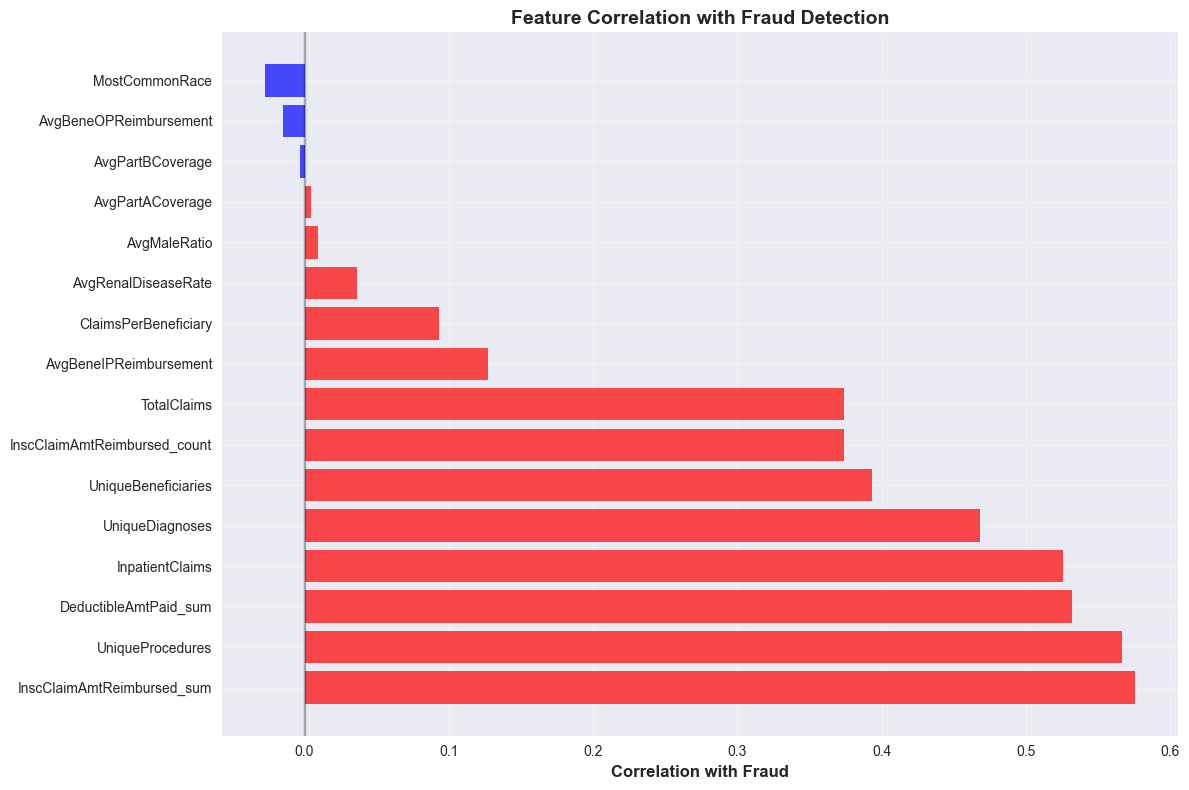

In [97]:
# Correlation analysis
print("=== Feature Correlation Analysis ===")

# Calculate correlations with target
feature_correlations = X.corrwith(y).sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(feature_correlations.head(10))
print("\nBottom 10 features correlated with fraud:")
print(feature_correlations.tail(10))

# Visualization of top correlations
plt.figure(figsize=(12, 8))
top_features = pd.concat([feature_correlations.head(8), feature_correlations.tail(8)])
colors = ['red' if x > 0 else 'blue' for x in top_features.values]

plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index, fontsize=10)
plt.xlabel('Correlation with Fraud', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Fraud Detection', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Export and Next Steps

In [ ]:
# Export the final dataset for modeling
print("=== Data Export for Modeling ===")

# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save the final processed dataset
final_dataset.to_csv('../data/provider_level.csv')
print(f"✅ Final dataset saved to: ../data/provider_level.csv")
print(f"Dataset shape: {final_dataset.shape}")
print(f"Features: {X.shape[1]} features, {X.shape[0]} providers")

# Save feature names for reference
feature_names = X.columns.tolist()
import pickle
with open('../data/feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"✅ Feature names saved to: ../data/feature_names.txt")
print(f"\n📋 Next Steps:")
print(f"  1. Run the modeling notebook: 02_modeling.ipynb")
print(f"  2. The dataset is ready for machine learning")
print(f"  3. Class imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1 (handled with class weights)")

✅ XGBoost available
ML libraries loaded successfully!


In [100]:
# Data preparation for modeling
print("=== Data Preparation for Modeling ===")

# Save the dataset
import os
os.makedirs('./data', exist_ok=True)
final_dataset.to_csv('./data/provider_level.csv')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights and scale_pos_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class weights: {class_weight_dict}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✅ Data preparation complete!")

=== Data Preparation for Modeling ===
Training set: (4328, 27), Test set: (1082, 27)
Class weights: {np.int64(0): np.float64(0.5516186591893959), np.int64(1): np.float64(5.3432098765432094)}
Scale pos weight: 9.69
✅ Data preparation complete!


In [101]:
# Model evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba):
    """Comprehensive model evaluation"""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='binary'),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'F1': f1_score(y_true, y_pred, average='binary'),
        'ROC_AUC': roc_auc_score(y_true, y_pred_proba),
        'PR_AUC': average_precision_score(y_true, y_pred_proba)
    }

# Define models with class weighting
models = {
    'Logistic_Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ]),
    'Random_Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100))
    ]),
    'Decision_Tree': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10))
    ]),
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('classifier', SVC(class_weight='balanced', random_state=42, probability=True))
    ])
}

if xgb is not None:
    models['XGBoost'] = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('classifier', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss'))
    ])

print(f"✅ {len(models)} models defined: {list(models.keys())}")

✅ 5 models defined: ['Logistic_Regression', 'Random_Forest', 'Decision_Tree', 'SVM', 'XGBoost']


In [102]:
# Train and evaluate all models
print("=== Model Training and Evaluation ===")

results = []
trained_models = {}

for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred_test = pipeline.predict(X_test)
        y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]
        
        # Evaluate
        metrics = evaluate_model(y_test, y_pred_test, y_pred_proba_test)
        metrics['Model'] = name
        results.append(metrics)
        
        # Store trained model
        trained_models[name] = pipeline
        
        print(f"  F1: {metrics['F1']:.4f}, PR-AUC: {metrics['PR_AUC']:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {e}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(results_df.round(4))

=== Model Training and Evaluation ===

Training Logistic_Regression...
  F1: 0.5455, PR-AUC: 0.7446

Training Random_Forest...
  F1: 0.6316, PR-AUC: 0.7480

Training Decision_Tree...
  F1: 0.5230, PR-AUC: 0.4533

Training SVM...
  F1: 0.5506, PR-AUC: 0.5398

Training XGBoost...
  F1: 0.6635, PR-AUC: 0.7306

=== Model Comparison Results ===
   Accuracy  Precision  Recall      F1  ROC_AUC  PR_AUC                Model
0    0.8614     0.3930  0.8911  0.5455   0.9560  0.7446  Logistic_Regression
1    0.9418     0.7714  0.5347  0.6316   0.9537  0.7480        Random_Forest
2    0.8752     0.4066  0.7327  0.5230   0.8268  0.4533        Decision_Tree
3    0.8688     0.4047  0.8614  0.5506   0.9408  0.5398                  SVM
4    0.9353     0.6449  0.6832  0.6635   0.9442  0.7306              XGBoost


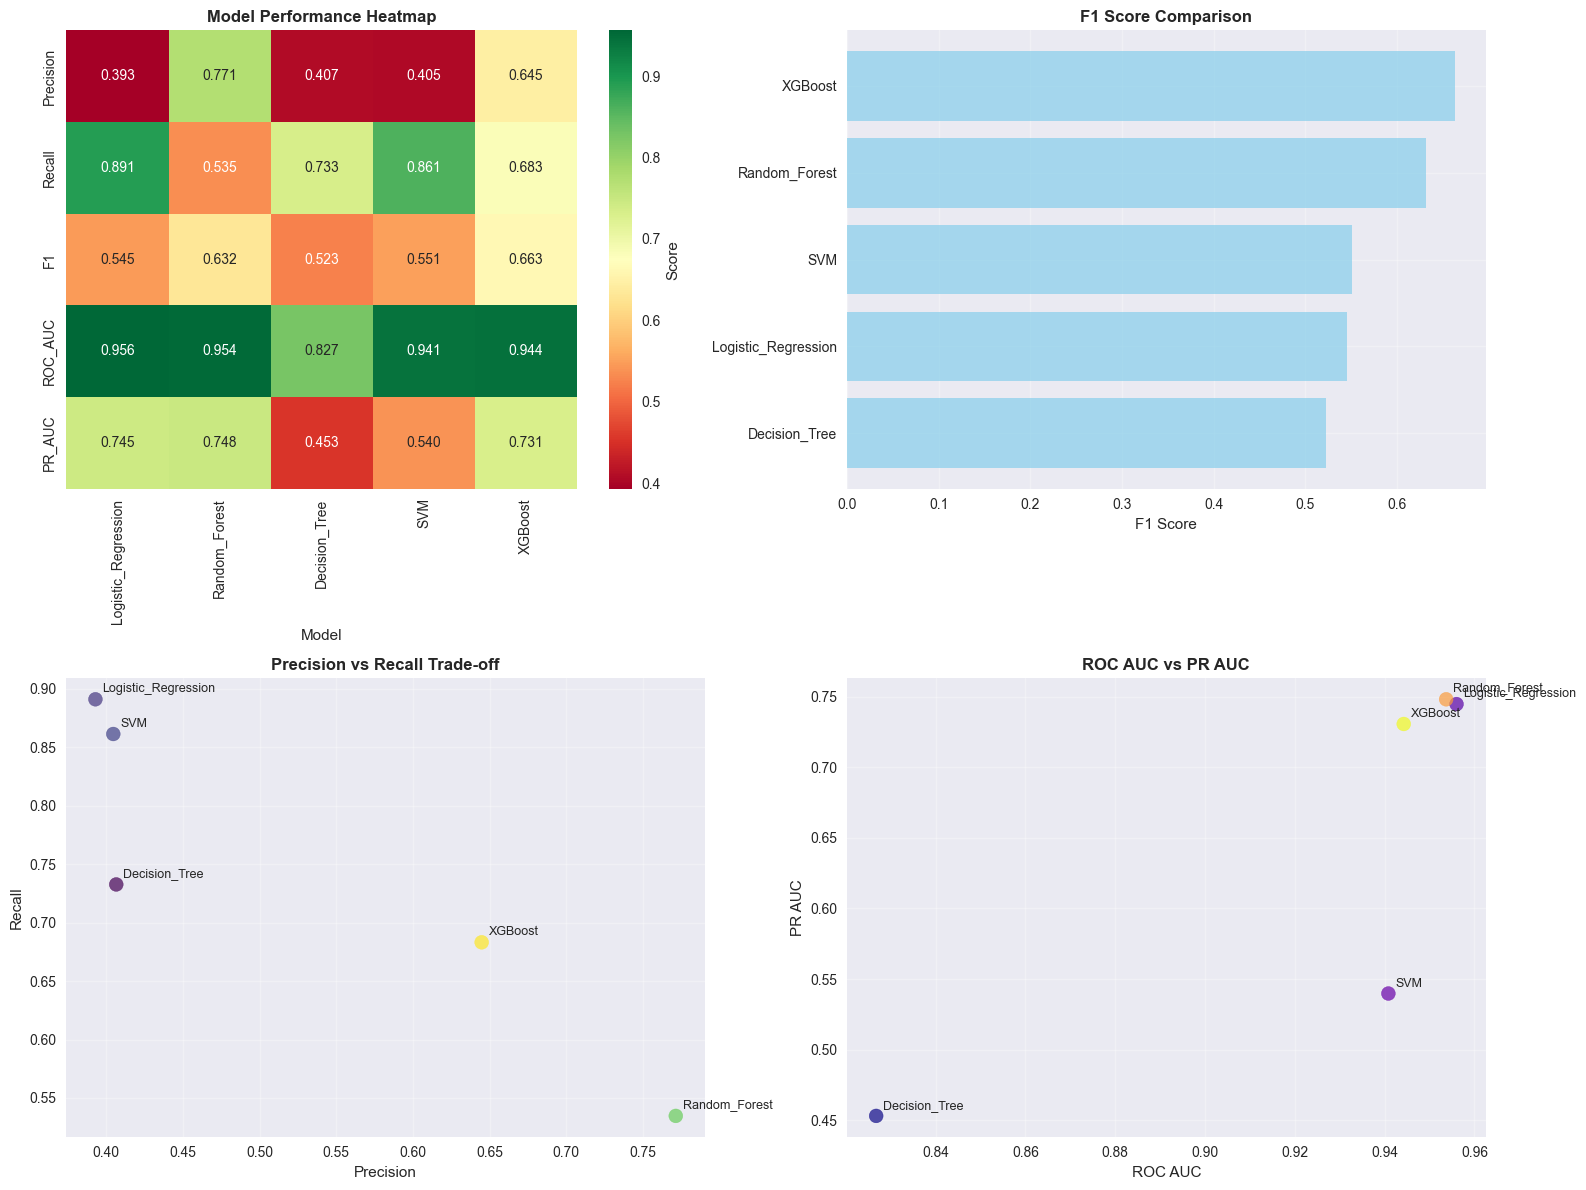


=== BEST MODEL BY F1-SCORE ===
Model: XGBoost
F1-Score: 0.6635
Precision: 0.6449
Recall: 0.6832
PR-AUC: 0.7306


In [103]:
# Model comparison visualization
if len(results_df) > 0:
    # Performance metrics heatmap
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Performance heatmap
    metrics_cols = ['Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']
    heatmap_data = results_df.set_index('Model')[metrics_cols]
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
                ax=axes[0,0], cbar_kws={'label': 'Score'})
    axes[0,0].set_title('Model Performance Heatmap', fontweight='bold')
    
    # 2. F1 Score comparison
    f1_scores = results_df.sort_values('F1', ascending=True)
    axes[0,1].barh(f1_scores['Model'], f1_scores['F1'], color='skyblue', alpha=0.7)
    axes[0,1].set_xlabel('F1 Score')
    axes[0,1].set_title('F1 Score Comparison', fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Precision vs Recall
    axes[1,0].scatter(results_df['Precision'], results_df['Recall'], 
                     c=results_df['F1'], cmap='viridis', s=100, alpha=0.7)
    for i, model in enumerate(results_df['Model']):
        axes[1,0].annotate(model, 
                          (results_df.iloc[i]['Precision'], results_df.iloc[i]['Recall']),
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1,0].set_xlabel('Precision')
    axes[1,0].set_ylabel('Recall')
    axes[1,0].set_title('Precision vs Recall Trade-off', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. ROC vs PR AUC
    axes[1,1].scatter(results_df['ROC_AUC'], results_df['PR_AUC'], 
                     c=results_df['F1'], cmap='plasma', s=100, alpha=0.7)
    for i, model in enumerate(results_df['Model']):
        axes[1,1].annotate(model, 
                          (results_df.iloc[i]['ROC_AUC'], results_df.iloc[i]['PR_AUC']),
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[1,1].set_xlabel('ROC AUC')
    axes[1,1].set_ylabel('PR AUC')
    axes[1,1].set_title('ROC AUC vs PR AUC', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Best model summary
    best_f1_model = results_df.loc[results_df['F1'].idxmax()]
    print("\n=== BEST MODEL BY F1-SCORE ===")
    print(f"Model: {best_f1_model['Model']}")
    print(f"F1-Score: {best_f1_model['F1']:.4f}")
    print(f"Precision: {best_f1_model['Precision']:.4f}")
    print(f"Recall: {best_f1_model['Recall']:.4f}")
    print(f"PR-AUC: {best_f1_model['PR_AUC']:.4f}")

## 6. Results and Recommendations

In [104]:
# Final recommendations
if len(results_df) > 0:
    print("="*60)
    print("HEALTHCARE FRAUD DETECTION - FINAL RECOMMENDATIONS")
    print("="*60)
    
    best_model = results_df.loc[results_df['F1'].idxmax()]
    
    print(f"\n🎯 RECOMMENDED MODEL: {best_model['Model']}")
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"  • F1-Score: {best_model['F1']:.4f}")
    print(f"  • Precision: {best_model['Precision']:.4f}")
    print(f"  • Recall: {best_model['Recall']:.4f}")
    print(f"  • PR-AUC: {best_model['PR_AUC']:.4f}")
    
    fraud_detected = int(best_model['Recall'] * (y_test == 1).sum())
    total_fraud = (y_test == 1).sum()
    
    print(f"\n📈 BUSINESS IMPACT:")
    print(f"  • Fraud cases detected: {fraud_detected} out of {total_fraud}")
    print(f"  • Detection rate: {best_model['Recall']:.1%}")
    print(f"  • Precision rate: {best_model['Precision']:.1%}")
    
    print(f"\n🏆 CLASS IMBALANCE STRATEGY: Class Weighting")
    print(f"  • Maintains original data distribution")
    print(f"  • Avoids synthetic data problems")
    print(f"  • Computationally efficient")
    
    print(f"\n🔧 DEPLOYMENT RECOMMENDATIONS:")
    print(f"  1. Implement {best_model['Model']} as primary detection system")
    print(f"  2. Use class weighting for imbalance handling")
    print(f"  3. Set threshold based on business cost considerations")
    print(f"  4. Regular model retraining (quarterly recommended)")
    print(f"  5. Monitor feature importance for model transparency")
    print(f"  6. Implement alerts for significant performance drift")
    
    # Save results
    results_df.to_csv('./data/model_results.csv', index=False)
    print(f"\n💾 Results saved to: ./data/model_results.csv")
    
    print(f"\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
else:
    print("⚠️ No models were successfully trained. Please check your data and try again.")

HEALTHCARE FRAUD DETECTION - FINAL RECOMMENDATIONS

🎯 RECOMMENDED MODEL: XGBoost

📊 PERFORMANCE METRICS:
  • F1-Score: 0.6635
  • Precision: 0.6449
  • Recall: 0.6832
  • PR-AUC: 0.7306

📈 BUSINESS IMPACT:
  • Fraud cases detected: 69 out of 101
  • Detection rate: 68.3%
  • Precision rate: 64.5%

🏆 CLASS IMBALANCE STRATEGY: Class Weighting
  • Maintains original data distribution
  • Avoids synthetic data problems
  • Computationally efficient

🔧 DEPLOYMENT RECOMMENDATIONS:
  1. Implement XGBoost as primary detection system
  2. Use class weighting for imbalance handling
  3. Set threshold based on business cost considerations
  4. Regular model retraining (quarterly recommended)
  5. Monitor feature importance for model transparency
  6. Implement alerts for significant performance drift

💾 Results saved to: ./data/model_results.csv

ANALYSIS COMPLETE
